In [1]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import random as random 
import math

Import data

In [2]:
df = pd.read_csv("df2.csv")

In [3]:
df.shape

(589, 17)

# KPI

In [5]:
df.dtypes

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
age                  float64
LoanAmountScale      float64
TotalIncome          float64
MonthlyPayment       float64
DebtToIncomeRatio    float64
TotalIncomeCut        object
dtype: object

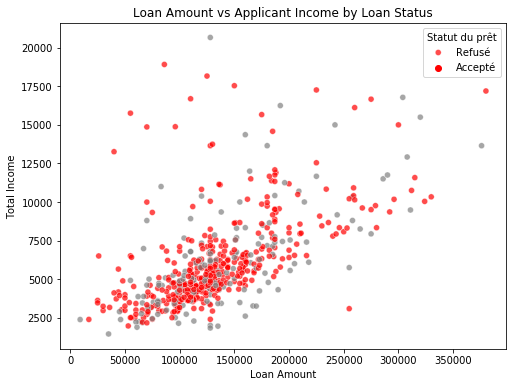

In [6]:


plt.figure(figsize=(8,6))

# Scatter plot avec couleur selon statut
sns.scatterplot(data=df, x='LoanAmountScale', y='TotalIncome', 
                hue='Loan_Status', 
                palette={'Y': 'red', 'N': 'gray'},
                alpha=0.7)

plt.xlabel("Loan Amount")
plt.ylabel("Total Income")
plt.title("Loan Amount vs Applicant Income by Loan Status")

# Optionnel : légende personnalisée
plt.legend(title='Statut du prêt', labels=['Refusé', 'Accepté'])

plt.show()


In [24]:
variables = ["Gender", "Education", "Married"]
results = []

for var in variables:
    contingency = pd.crosstab(df[var], df["Loan_Status"])
    chi2, p, dof, _ = stats.chi2_contingency(contingency)
    results.append({
        "Variable": var,
        "Chi2 Statistic": chi2,
        "Degrees of Freedom": dof,
        "p-value": p
    })

df_results = pd.DataFrame(results)
df_results["Interpretation"] = df_results["p-value"].apply(
    lambda p: "Significant (p < 0.05)" if p < 0.05 else "Not significant"
)


df_results_display = df_results.copy()
df_results_display["Chi2 Statistic"] = df_results_display["Chi2 Statistic"].round(3)
df_results_display["p-value"] = df_results_display["p-value"].apply(lambda x: f"{x:.4f}")

print("\n=== Chi-square Test Results ===\n")
print(df_results_display.to_string(index=False))




=== Chi-square Test Results ===

  Variable  Chi2 Statistic  Degrees of Freedom p-value          Interpretation
    Gender           0.174                   1  0.6762         Not significant
 Education           4.610                   1  0.0318  Significant (p < 0.05)
   Married           4.907                   1  0.0268  Significant (p < 0.05)


In [34]:
group_accepted = df[df["Loan_Status"] == "Y"]["age"]
group_refused = df[df["Loan_Status"] == "N"]["age"]

t_stat, p_val = stats.ttest_ind(group_accepted, group_refused, equal_var=False) 

print(f"T-test statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print("Result: Significant difference in mean age between loan status groups.")
else:
    print("Result: No significant difference in mean age between loan status groups.")


T-test statistic: -2.868
P-value: 0.0045
Result: Significant difference in mean age between loan status groups.


In [31]:
def num_cat(df): 
    cat_cols = df.select_dtypes(include='object').columns
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    return df



In [32]:
df_encoding = num_cat(df)

In [33]:
df_encoding.head()

,ApplicantIncome,CoapplicantIncome,Loan_Amount_Term,Credit_History,age,LoanAmountScale,TotalIncome,MonthlyPayment,DebtToIncomeRatio,Dependents_clean,...,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y,TotalIncomeCut_2nd part,TotalIncomeCut_3rd part,TotalIncomeCut_4th part,TotalIncomeCut_5th part,Dependents_num_0,Dependents_num_1,Dependents_num_2
0,5849,0.0,360.0,1.0,45.0,128000.0,5849.0,355.555556,0.060789,0.0,...,0,1,1,1,0,0,0,1,0,0
1,4583,1508.0,360.0,1.0,48.0,128000.0,6091.0,355.555556,0.058374,1.0,...,0,0,0,1,0,0,0,0,1,0
2,3000,0.0,360.0,1.0,34.0,66000.0,3000.0,183.333333,0.061111,0.0,...,0,1,1,0,0,0,0,1,0,0
3,2583,2358.0,360.0,1.0,34.0,120000.0,4941.0,333.333333,0.067463,0.0,...,0,1,1,0,0,0,0,1,0,0
4,6000,0.0,360.0,1.0,38.0,141000.0,6000.0,391.666667,0.065278,0.0,...,0,1,1,1,0,0,0,1,0,0


In [ ]:
df.isnull().sum()

In [ ]:
X = df_encoding.drop('Loan_Status_Y', axis=1)
y = df_encoding['Loan_Status_Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 5️⃣ Entraînement de la régression logistique ---
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg.fit(X_train, y_train)

# --- 6️⃣ Prédiction et évaluation ---
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:,1]  # Probabilité d'approbation du prêt

print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("\nRapport de classification :\n", classification_report(y_test, y_pred))
print("\nAUC Score :", roc_auc_score(y_test, y_proba))

In [ ]:

rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_proba_rf = rf.predict_proba(X_test)[:,1]
y_pred_rf = (y_proba_rf >= 0.5).astype(int)
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_rf))
print("\nRapport de classification :\n", classification_report(y_test, y_pred_rf))
print("\nAUC Score :", roc_auc_score(y_test, y_pred_rf))

In [ ]:
# rf est ton modèle RandomForestClassifier entraîné
arbres = rf.estimators_

# arbres est une liste d'objets DecisionTreeClassifier
print(f"Nombre d'arbres dans la forêt : {len(arbres)}")

# Par exemple, pour afficher le premier arbre :
arbre1 = arbres[0]
print(arbre1)

# Tu peux aussi exporter un arbre en visualisation avec sklearn.tree.plot_tree ou export_graphviz
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(arbre1, filled=True, max_depth=3, feature_names=X_train.columns, class_names=['0', '1'])
plt.show()


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2', None],
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1)
random_search.fit(X_train, y_train)

print("Best parameters :", random_search.best_params_)
print("Best AUC score :", random_search.best_score_)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_optimized = RandomForestClassifier(
    n_estimators=156,
    max_depth=4,
    max_features='auto',
    min_samples_leaf=8,
    min_samples_split=3,
    class_weight='balanced',
    random_state=42
)

rf_optimized.fit(X_train, y_train)

# Prédictions
y_proba = rf_optimized.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

# Évaluation
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("\nRapport de classification :\n", classification_report(y_test, y_pred))
print("\nAUC Score :", roc_auc_score(y_test, y_proba))
